# Paper 2: Data Preparation

## Extract 2D Slices from OASIS-2 3D NIfTI Volumes

This notebook:
1. Loads OASIS demographics (CDR scores for labeling)
2. Extracts 2D slices from 3D MRI volumes (targeting ~6,400 slices)
3. Preprocesses slices (resize, normalize, RGB conversion)
4. Creates binary labels (Demented vs Non-Demented)
5. Performs train-test split (80/20)
6. Saves processed data for model training

**Dataset:** OASIS-2 Raw MRI (1,367 3D volumes → ~6,400 2D slices)

## 1. Load Utilities and Configuration

In [2]:
# Run the utilities notebook to load all functions and config
%run 00_utils_and_config.ipynb

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA version: 13.0
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Device: cuda
Configuration loaded successfully!

Base path: C:\Users\rishi\CV_Assignment\Paper2
Raw data path: C:\Users\rishi\CV_Assignment\Paper2\Raw_Data
Number of models: 5
Data processing functions loaded successfully!
Evaluation metrics functions loaded successfully!
Visualization functions loaded successfully!
Data augmentation setup loaded successfully!

PAPER 2 UTILITIES AND CONFIGURATION - SUMMARY

✓ All libraries imported successfully
✓ Configuration parameters loaded
✓ Data processing functions defined
✓ Evaluation metrics functions defined
✓ Visualization functions defined
✓ Data augmentation configured

Ready to proceed with:
  - Notebook 01: Data Preparation
  - Notebooks 02-06: Model Implementations
  - Notebook 07: Results Comparison



## 2. Load OASIS Demographics and Create Label Mapping

In [3]:
# Load demographics file
demographics_path = CONFIG['demographics_file']
print(f"Loading demographics from: {demographics_path}\n")

df_demographics = load_demographics(demographics_path)
print(f"Demographics loaded: {len(df_demographics)} records\n")

# Display first few rows
print("First 5 records:")
print(df_demographics.head())

# Display column names
print(f"\nColumns: {list(df_demographics.columns)}")

Loading demographics from: ..\Raw_Data\OASIS_demographic.xlsx

Demographics loaded: 373 records

First 5 records:
  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR         eTIV      nWBV       ASF  
0  2.0  27.0  0.0  1986.550000  0.696106  0.883440  
1  2.0  30.0  0.0  2004.479526  0.681062  0.875539  
2  NaN  23.0  0.5  1678.290000  0.736336  1.045710  
3  NaN  28.0  0.5  1737.620000  0.713402  1.010000  
4  NaN  22.0  0.5  1697.911134  0.701236  1.033623  

Columns: ['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand', '

In [4]:
# Extract relevant columns (adjust column names based on actual Excel file)
# Typical OASIS-2 columns: 'Subject ID', 'MRI ID', 'Visit', 'CDR', 'Age', 'MMSE', etc.

# Create binary labels from CDR scores
# CDR >= 0.5 = Demented (1), CDR = 0 = Non-Demented (0)
if 'CDR' in df_demographics.columns:
    df_demographics['Binary_Label'] = df_demographics['CDR'].apply(
        lambda x: get_binary_label(x, threshold=CONFIG['cdr_threshold'])
    )
    
    # Remove rows with missing CDR scores
    df_demographics = df_demographics.dropna(subset=['Binary_Label'])
    df_demographics['Binary_Label'] = df_demographics['Binary_Label'].astype(int)
    
    print(f"\nTotal records with valid CDR scores: {len(df_demographics)}")
    print(f"\nClass distribution:")
    print(df_demographics['Binary_Label'].value_counts())
    print(f"\n  0 (Non-Demented): {(df_demographics['Binary_Label'] == 0).sum()}")
    print(f"  1 (Demented):     {(df_demographics['Binary_Label'] == 1).sum()}")
else:
    print("\nWarning: 'CDR' column not found. Please adjust column name.")
    print(f"Available columns: {list(df_demographics.columns)}")


Total records with valid CDR scores: 373

Class distribution:
Binary_Label
0    206
1    167
Name: count, dtype: int64

  0 (Non-Demented): 206
  1 (Demented):     167


In [5]:
# Create a mapping from MRI ID to label
# OASIS-2 format: OAS2_XXXX_MRY
if 'MRI ID' in df_demographics.columns:
    label_mapping = dict(zip(df_demographics['MRI ID'], df_demographics['Binary_Label']))
    print(f"\nLabel mapping created for {len(label_mapping)} MRI sessions")
    print(f"\nSample mappings:")
    for mri_id, label in list(label_mapping.items())[:5]:
        label_name = CONFIG['class_names'][label]
        print(f"  {mri_id}: {label} ({label_name})")
else:
    print("\nWarning: 'MRI ID' column not found. Please adjust column name.")


Label mapping created for 373 MRI sessions

Sample mappings:
  OAS2_0001_MR1: 0 (Non-Demented)
  OAS2_0001_MR2: 0 (Non-Demented)
  OAS2_0002_MR1: 1 (Demented)
  OAS2_0002_MR2: 1 (Demented)
  OAS2_0002_MR3: 1 (Demented)


## 3. Scan Raw Data Directory and Collect NIfTI Files

In [6]:
# Scan both OAS2_RAW_PART1 and OAS2_RAW_PART2 directories
raw_data_path = CONFIG['raw_data_path']
part1_path = raw_data_path / 'OAS2_RAW_PART1'
part2_path = raw_data_path / 'OAS2_RAW_PART2'

print(f"Scanning raw data directories...\n")

# Collect all .hdr files (NIfTI headers)
nifti_files = []

for part_path in [part1_path, part2_path]:
    if part_path.exists():
        print(f"Scanning: {part_path.name}")
        # Find all mpr-*.nifti.hdr files in RAW subdirectories
        hdr_files = list(part_path.rglob('RAW/mpr-*.nifti.hdr'))
        nifti_files.extend(hdr_files)
        print(f"  Found {len(hdr_files)} NIfTI header files")

print(f"\nTotal NIfTI files found: {len(nifti_files)}")

# Sample file paths
print(f"\nSample file paths:")
for i, file_path in enumerate(nifti_files[:3]):
    print(f"  {i+1}. {file_path}")

Scanning raw data directories...

Scanning: OAS2_RAW_PART1
  Found 771 NIfTI header files
Scanning: OAS2_RAW_PART2
  Found 596 NIfTI header files

Total NIfTI files found: 1367

Sample file paths:
  1. ..\Raw_Data\OAS2_RAW_PART1\OAS2_0001_MR1\RAW\mpr-1.nifti.hdr
  2. ..\Raw_Data\OAS2_RAW_PART1\OAS2_0001_MR1\RAW\mpr-2.nifti.hdr
  3. ..\Raw_Data\OAS2_RAW_PART1\OAS2_0001_MR1\RAW\mpr-3.nifti.hdr


In [7]:
# Extract MRI session IDs from file paths
# Path format: .../OAS2_XXXX_MRY/RAW/mpr-N.nifti.hdr
def extract_mri_id_from_path(file_path):
    """Extract MRI session ID (OAS2_XXXX_MRY) from file path."""
    # Convert to Path object if it isn't already
    path_obj = Path(file_path) if not isinstance(file_path, Path) else file_path
    parts = path_obj.parts
    for part in parts:
        if part.startswith('OAS2_') and '_MR' in part:
            return part
    return None

# Create list of (file_path, mri_id, label) tuples
file_label_pairs = []

print(f"Matching NIfTI files to labels...")
print(f"Total NIfTI files to process: {len(nifti_files)}")
print(f"Total MRI IDs in label mapping: {len(label_mapping)}\n")

# Debug: Show sample matching
matched_count = 0
unmatched_count = 0
sample_matches = []

for file_path in nifti_files:
    mri_id = extract_mri_id_from_path(file_path)
    
    if mri_id and mri_id in label_mapping:
        label = label_mapping[mri_id]
        file_label_pairs.append((file_path, mri_id, label))
        matched_count += 1
        
        # Store first 5 matches as samples
        if len(sample_matches) < 5:
            sample_matches.append((str(file_path), mri_id, label))
    else:
        unmatched_count += 1

print(f"Matching complete!")
print(f"  Matched: {matched_count}")
print(f"  Unmatched: {unmatched_count}")
print(f"\nSample matches:")
for path, mri_id, label in sample_matches:
    label_name = CONFIG['class_names'][label]
    # Show just the filename portion for readability
    filename = Path(path).name
    parent_dir = Path(path).parent.parent.name
    print(f"  {parent_dir}/.../{filename} -> {mri_id} -> {label} ({label_name})")

print(f"\nNIfTI files with valid labels: {len(file_label_pairs)}")

# Check class distribution
if file_label_pairs:
    labels_only = [label for _, _, label in file_label_pairs]
    non_demented_count = labels_only.count(0)
    demented_count = labels_only.count(1)
    
    print(f"\nClass distribution in matched files:")
    print(f"  Non-Demented (0): {non_demented_count} volumes")
    print(f"  Demented (1):     {demented_count} volumes")
else:
    print("\n⚠️  WARNING: No files matched! Check the following:")
    print(f"  1. Sample file path: {nifti_files[0]}")
    print(f"  2. Extracted MRI ID: {extract_mri_id_from_path(nifti_files[0])}")
    print(f"  3. Sample label mapping keys: {list(label_mapping.keys())[:3]}")

Matching NIfTI files to labels...
Total NIfTI files to process: 1367
Total MRI IDs in label mapping: 373

Matching complete!
  Matched: 1367
  Unmatched: 0

Sample matches:
  OAS2_0001_MR1/.../mpr-1.nifti.hdr -> OAS2_0001_MR1 -> 0 (Non-Demented)
  OAS2_0001_MR1/.../mpr-2.nifti.hdr -> OAS2_0001_MR1 -> 0 (Non-Demented)
  OAS2_0001_MR1/.../mpr-3.nifti.hdr -> OAS2_0001_MR1 -> 0 (Non-Demented)
  OAS2_0001_MR2/.../mpr-1.nifti.hdr -> OAS2_0001_MR2 -> 0 (Non-Demented)
  OAS2_0001_MR2/.../mpr-2.nifti.hdr -> OAS2_0001_MR2 -> 0 (Non-Demented)

NIfTI files with valid labels: 1367

Class distribution in matched files:
  Non-Demented (0): 753 volumes
  Demented (1):     614 volumes


## 4. Extract 2D Slices from 3D Volumes

In [8]:
# Calculate how many slices per volume we need to reach ~6,400 total slices
target_total = CONFIG['target_total_images']
num_volumes = len(file_label_pairs)

# Check if we have any volumes to process
if num_volumes == 0:
    print("❌ ERROR: No volumes with valid labels found!")
    print("\nPlease check:")
    print("  1. Are the NIfTI files in the correct directories?")
    print("  2. Do the file paths contain MRI IDs matching the demographics file?")
    print("  3. Run the previous cell again to see detailed matching information.")
    print("\nCannot proceed with slice extraction.")
else:
    slices_per_volume = max(1, target_total // num_volumes)
    
    print(f"Target total slices: {target_total}")
    print(f"Available volumes: {num_volumes}")
    print(f"Slices per volume: {slices_per_volume}")
    print(f"Expected total slices: {num_volumes * slices_per_volume}\n")
    
    print("Starting slice extraction... (this may take several minutes)\n")

Target total slices: 6400
Available volumes: 1367
Slices per volume: 4
Expected total slices: 5468

Starting slice extraction... (this may take several minutes)



In [9]:
# Extract slices in two sizes for different models
# Size 224x224 for models 1, 4, 5
# Size 128x128 for models 2, 3

slices_224 = []
slices_128 = []
slice_labels = []
slice_metadata = []  # Store (mri_id, slice_idx) for tracking

# Process each volume
failed_count = 0
success_count = 0
skipped_slices = 0

for idx, (file_path, mri_id, label) in enumerate(file_label_pairs):
    if (idx + 1) % 50 == 0:
        print(f"Processing volume {idx + 1}/{num_volumes}...")
    
    # Load 3D volume
    volume = load_nifti_volume(file_path)
    
    if volume is None:
        failed_count += 1
        continue
    
    # Extract representative 2D slices
    slices_2d = extract_representative_slices(volume, num_slices=slices_per_volume, axis=2)
    
    if len(slices_2d) == 0:
        failed_count += 1
        continue
    
    # Preprocess each slice in both sizes
    for slice_idx, slice_2d in enumerate(slices_2d):
        # Preprocess to 224x224
        slice_224 = preprocess_slice(slice_2d, target_size=(224, 224), normalize=False, to_rgb=True)
        
        # Preprocess to 128x128
        slice_128 = preprocess_slice(slice_2d, target_size=(128, 128), normalize=False, to_rgb=True)
        
        # Skip invalid slices
        if slice_224 is None or slice_128 is None:
            skipped_slices += 1
            continue
        
        slices_224.append(slice_224)
        slices_128.append(slice_128)
        
        # Store label and metadata
        slice_labels.append(label)
        slice_metadata.append((mri_id, slice_idx))
    
    success_count += 1

print(f"\nSlice extraction complete!")
print(f"  Successful volumes: {success_count}")
print(f"  Failed volumes: {failed_count}")
print(f"  Skipped invalid slices: {skipped_slices}")
print(f"  Total slices extracted (224x224): {len(slices_224)}")
print(f"  Total slices extracted (128x128): {len(slices_128)}")

Processing volume 50/1367...
Processing volume 100/1367...
Processing volume 150/1367...
Processing volume 200/1367...
Processing volume 250/1367...
Processing volume 300/1367...
Processing volume 350/1367...
Processing volume 400/1367...
Processing volume 450/1367...
Processing volume 500/1367...
Processing volume 550/1367...
Processing volume 600/1367...
Processing volume 650/1367...
Processing volume 700/1367...
Processing volume 750/1367...
Processing volume 800/1367...
Processing volume 850/1367...
Processing volume 900/1367...
Processing volume 950/1367...
Processing volume 1000/1367...
Processing volume 1050/1367...
Processing volume 1100/1367...
Processing volume 1150/1367...
Processing volume 1200/1367...
Processing volume 1250/1367...
Processing volume 1300/1367...
Processing volume 1350/1367...

Slice extraction complete!
  Successful volumes: 1367
  Failed volumes: 0
  Skipped invalid slices: 0
  Total slices extracted (224x224): 5468
  Total slices extracted (128x128): 546

In [10]:
# Convert to numpy arrays
X_224 = np.array(slices_224, dtype=np.uint8)
X_128 = np.array(slices_128, dtype=np.uint8)
y = np.array(slice_labels, dtype=np.int32)

print(f"\nArray shapes:")
print(f"  X_224: {X_224.shape}")
print(f"  X_128: {X_128.shape}")
print(f"  y:     {y.shape}")

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print(f"\nFinal class distribution:")
for class_idx, count in zip(unique, counts):
    class_name = CONFIG['class_names'][class_idx]
    percentage = (count / len(y)) * 100
    print(f"  {class_name} ({class_idx}): {count} slices ({percentage:.1f}%)")


Array shapes:
  X_224: (5468, 224, 224, 3)
  X_128: (5468, 128, 128, 3)
  y:     (5468,)

Final class distribution:
  Non-Demented (0): 3012 slices (55.1%)
  Demented (1): 2456 slices (44.9%)


## 5. Visualize Sample Slices

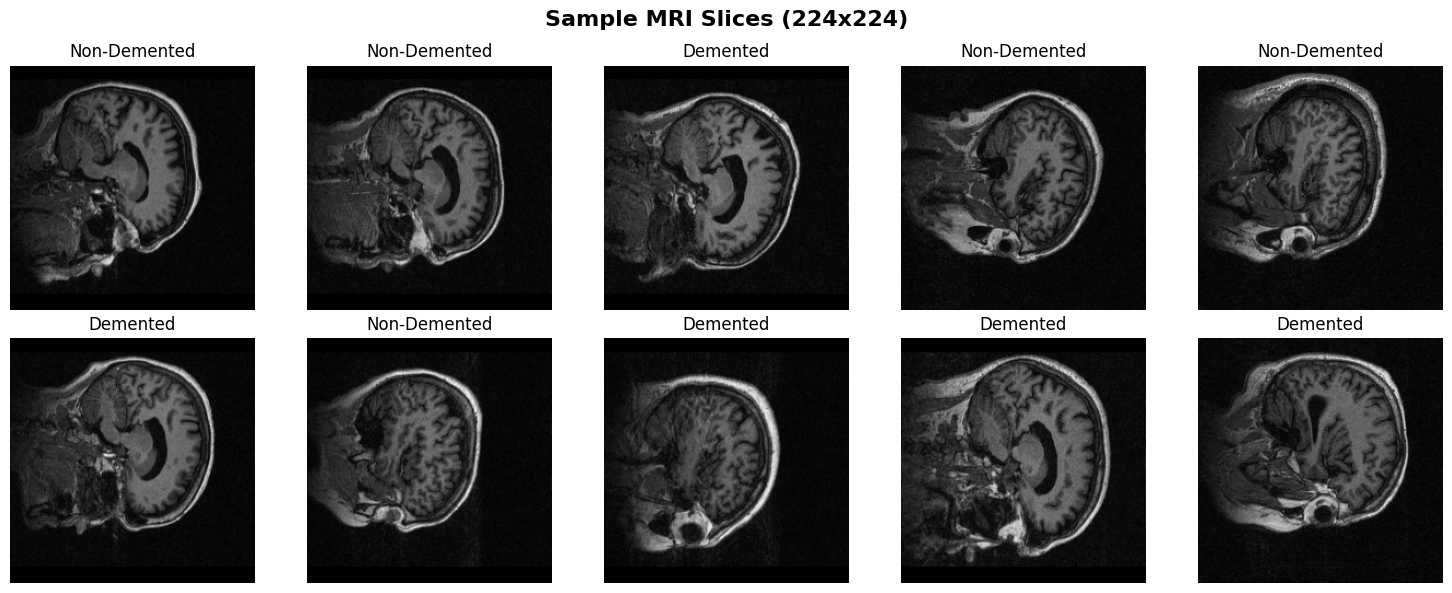

In [11]:
# Plot sample slices from both classes
plot_sample_slices(X_224, y, CONFIG['class_names'], num_samples=10, 
                   title="Sample MRI Slices (224x224)")

## 6. Train-Test Split

In [12]:
# Perform stratified split (80% train, 20% test)
train_split = CONFIG['train_split']
random_state = CONFIG['random_state']

# Split indices for both sizes
indices = np.arange(len(y))
train_idx, test_idx = train_test_split(
    indices, 
    test_size=1-train_split, 
    random_state=random_state, 
    stratify=y
)

# Create train/test splits for 224x224
X_train_224 = X_224[train_idx]
X_test_224 = X_224[test_idx]

# Create train/test splits for 128x128
X_train_128 = X_128[train_idx]
X_test_128 = X_128[test_idx]

# Labels (same for both)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"Train-Test Split (stratified):")
print(f"\n224x224 images:")
print(f"  Training set:   {X_train_224.shape}")
print(f"  Test set:       {X_test_224.shape}")
print(f"\n128x128 images:")
print(f"  Training set:   {X_train_128.shape}")
print(f"  Test set:       {X_test_128.shape}")
print(f"\nLabels:")
print(f"  Training set:   {y_train.shape}")
print(f"  Test set:       {y_test.shape}")

# Check class distribution in splits
print(f"\nTraining set class distribution:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for class_idx, count in zip(train_unique, train_counts):
    class_name = CONFIG['class_names'][class_idx]
    percentage = (count / len(y_train)) * 100
    print(f"  {class_name} ({class_idx}): {count} ({percentage:.1f}%)")

print(f"\nTest set class distribution:")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for class_idx, count in zip(test_unique, test_counts):
    class_name = CONFIG['class_names'][class_idx]
    percentage = (count / len(y_test)) * 100
    print(f"  {class_name} ({class_idx}): {count} ({percentage:.1f}%)")

Train-Test Split (stratified):

224x224 images:
  Training set:   (4374, 224, 224, 3)
  Test set:       (1094, 224, 224, 3)

128x128 images:
  Training set:   (4374, 128, 128, 3)
  Test set:       (1094, 128, 128, 3)

Labels:
  Training set:   (4374,)
  Test set:       (1094,)

Training set class distribution:
  Non-Demented (0): 2409 (55.1%)
  Demented (1): 1965 (44.9%)

Test set class distribution:
  Non-Demented (0): 603 (55.1%)
  Demented (1): 491 (44.9%)


## 7. Save Processed Data

In [13]:
# Save processed data to disk
processed_data_path = CONFIG['processed_data_path']

print(f"Saving processed data to: {processed_data_path}\n")

# Save 224x224 data
np.save(processed_data_path / 'X_train_224.npy', X_train_224)
np.save(processed_data_path / 'X_test_224.npy', X_test_224)
print(f"✓ Saved 224x224 images")

# Save 128x128 data
np.save(processed_data_path / 'X_train_128.npy', X_train_128)
np.save(processed_data_path / 'X_test_128.npy', X_test_128)
print(f"✓ Saved 128x128 images")

# Save labels
np.save(processed_data_path / 'y_train.npy', y_train)
np.save(processed_data_path / 'y_test.npy', y_test)
print(f"✓ Saved labels")

# Save metadata
metadata = {
    'total_slices': len(y),
    'train_size': len(y_train),
    'test_size': len(y_test),
    'train_split': train_split,
    'random_state': random_state,
    'class_names': CONFIG['class_names'],
    'train_indices': train_idx.tolist(),
    'test_indices': test_idx.tolist(),
    'class_distribution': {
        'train': {int(k): int(v) for k, v in zip(train_unique, train_counts)},
        'test': {int(k): int(v) for k, v in zip(test_unique, test_counts)}
    }
}

with open(processed_data_path / 'dataset_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Saved metadata")

# Calculate and display file sizes
print(f"\nFile sizes:")
for file_path in processed_data_path.glob('*.npy'):
    size_mb = file_path.stat().st_size / (1024 * 1024)
    print(f"  {file_path.name}: {size_mb:.1f} MB")

print(f"\n✓ All data saved successfully!")

Saving processed data to: ..\processed_data

✓ Saved 224x224 images
✓ Saved 128x128 images
✓ Saved labels
✓ Saved metadata

File sizes:
  X_test_128.npy: 51.3 MB
  X_test_224.npy: 157.0 MB
  X_train_128.npy: 205.0 MB
  X_train_224.npy: 627.9 MB
  y_test.npy: 0.0 MB
  y_train.npy: 0.0 MB

✓ All data saved successfully!


## 8. Summary

In [14]:
print("\n" + "="*80)
print("DATA PREPARATION - SUMMARY")
print("="*80)
print(f"\n✓ Demographics loaded: {len(df_demographics)} records")
print(f"✓ NIfTI volumes processed: {success_count}")
print(f"✓ Total 2D slices extracted: {len(y)}")
print(f"✓ Training samples: {len(y_train)} ({train_split*100:.0f}%)")
print(f"✓ Test samples: {len(y_test)} ({(1-train_split)*100:.0f}%)")
print(f"\nClass Balance:")
for class_idx in [0, 1]:
    class_name = CONFIG['class_names'][class_idx]
    train_count = (y_train == class_idx).sum()
    test_count = (y_test == class_idx).sum()
    total_count = train_count + test_count
    print(f"  {class_name}: {total_count} total ({train_count} train, {test_count} test)")

print(f"\nData saved to: {processed_data_path.resolve()}")
print(f"\n✓ Ready for model training!")
print(f"\nNext steps:")
print(f"  - Notebook 02: Train Model 1 (CNNs-without-Aug)")
print(f"  - Notebook 03: Train Model 2 (CNNs-with-Aug)")
print(f"  - Notebook 04: Train Model 3 (CNNs-LSTM-with-Aug) ⭐ BEST")
print(f"  - Notebook 05: Train Model 4 (CNNs-SVM-with-Aug)")
print(f"  - Notebook 06: Train Model 5 (VGG16-SVM-with-Aug)")
print("\n" + "="*80)


DATA PREPARATION - SUMMARY

✓ Demographics loaded: 373 records
✓ NIfTI volumes processed: 1367
✓ Total 2D slices extracted: 5468
✓ Training samples: 4374 (80%)
✓ Test samples: 1094 (20%)

Class Balance:
  Non-Demented: 3012 total (2409 train, 603 test)
  Demented: 2456 total (1965 train, 491 test)

Data saved to: C:\Users\rishi\CV_Assignment\Paper2\processed_data

✓ Ready for model training!

Next steps:
  - Notebook 02: Train Model 1 (CNNs-without-Aug)
  - Notebook 03: Train Model 2 (CNNs-with-Aug)
  - Notebook 04: Train Model 3 (CNNs-LSTM-with-Aug) ⭐ BEST
  - Notebook 05: Train Model 4 (CNNs-SVM-with-Aug)
  - Notebook 06: Train Model 5 (VGG16-SVM-with-Aug)



In [15]:
# Debug: Check what's happening with the path extraction
sample_path = Path(r"..\Raw_Data\OAS2_RAW_PART1\OAS2_0001_MR1\RAW\mpr-1.nifti.hdr")
print(f"Sample path: {sample_path}")
print(f"Path parts: {sample_path.parts}")

# Try the function
def extract_mri_id_from_path(file_path):
    """Extract MRI session ID (OAS2_XXXX_MRY) from file path."""
    parts = Path(file_path).parts
    for part in parts:
        if part.startswith('OAS2_'):
            return part
    return None

mri_id = extract_mri_id_from_path(sample_path)
print(f"\nExtracted MRI ID: {mri_id}")

# Check if it's in the label mapping
print(f"Is in label_mapping: {mri_id in label_mapping}")
print(f"\nFirst 5 keys in label_mapping:")
for key in list(label_mapping.keys())[:5]:
    print(f"  {key}")

Sample path: ..\Raw_Data\OAS2_RAW_PART1\OAS2_0001_MR1\RAW\mpr-1.nifti.hdr
Path parts: ('..', 'Raw_Data', 'OAS2_RAW_PART1', 'OAS2_0001_MR1', 'RAW', 'mpr-1.nifti.hdr')

Extracted MRI ID: OAS2_RAW_PART1
Is in label_mapping: False

First 5 keys in label_mapping:
  OAS2_0001_MR1
  OAS2_0001_MR2
  OAS2_0002_MR1
  OAS2_0002_MR2
  OAS2_0002_MR3


In [16]:
# Let's check the actual nifti_files to see what we're working with
print(f"Type of first nifti file: {type(nifti_files[0])}")
print(f"First nifti file: {nifti_files[0]}")
print(f"\nParts: {nifti_files[0].parts}")

# Test extraction
test_id = None
for part in nifti_files[0].parts:
    print(f"Checking part: '{part}' - starts with OAS2_: {part.startswith('OAS2_')}")
    if part.startswith('OAS2_'):
        test_id = part
        break
        
print(f"\nExtracted ID: {test_id}")
print(f"In label_mapping: {test_id in label_mapping if test_id else 'N/A'}")

Type of first nifti file: <class 'pathlib._local.WindowsPath'>
First nifti file: ..\Raw_Data\OAS2_RAW_PART1\OAS2_0001_MR1\RAW\mpr-1.nifti.hdr

Parts: ('..', 'Raw_Data', 'OAS2_RAW_PART1', 'OAS2_0001_MR1', 'RAW', 'mpr-1.nifti.hdr')
Checking part: '..' - starts with OAS2_: False
Checking part: 'Raw_Data' - starts with OAS2_: False
Checking part: 'OAS2_RAW_PART1' - starts with OAS2_: True

Extracted ID: OAS2_RAW_PART1
In label_mapping: False
